In [1]:
import random
random.seed(0)
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(10)
from itertools import count

In [2]:
N_CONTROLLER = 2

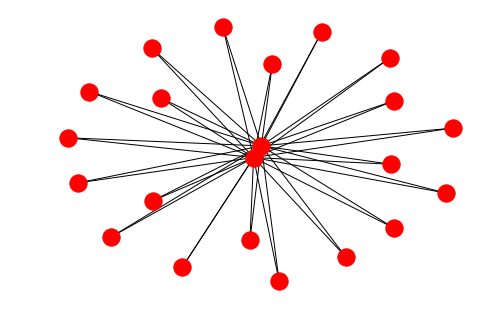

adjacent matrix
 [[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0

In [3]:
G = nx.Graph()

name2idx = {}

with open('topology/unv1.cdp.txt') as f:
    for line in f:
        src, src_inf, dst, dst_inf = line.split(' ')
        if src not in name2idx:
            src_idx = len(name2idx)
            name2idx[src] = src_idx
            G.add_node(src_idx)
        else:
            src_idx = name2idx[src]
            
        if dst not in name2idx:
            dst_idx = len(name2idx)
            name2idx[dst] = dst_idx
            G.add_node(dst_idx)
        else:
            dst_idx = name2idx[dst]
        
        G.add_edge(src_idx, dst_idx, latency = random.random() * 30)

nx.draw(G)
plt.show()
one = nx.adjacency_matrix(G)
print('adjacent matrix\n', one.todense())
A = nx.adjacency_matrix(G, weight = 'latency')
mat = A.todense()
pairs = dict(nx.all_pairs_dijkstra_path_length(G, weight = 'latency'))

In [4]:
N_SDN = len(mat)
path_lens = np.zeros((N_SDN, N_SDN))
for i in range(N_SDN):
    for j in range(N_SDN):
        path_lens[i][j] = pairs[i][j]

In [5]:
def find_centroids(short_path_len, K):
    N = short_path_len.shape[0]
    centroids = np.random.choice(N, K, replace = False) # without replacement
    
    n_iter = 0
    MAX_ITER = 100
    
    while n_iter < MAX_ITER:
        n_iter += 1
        print('iter', n_iter, '\ncentroids', centroids, '\n')
        
        short_path_to_centroid = np.full((N, N), np.finfo(float).max)
        short_path_to_centroid[centroids, :] = short_path_len[centroids, :]
        nearest_centroid = np.argmin(short_path_to_centroid, axis = 0)
        
        clusters = [[i for i, x in enumerate(nearest_centroid) if x == c] for c in centroids]
        new_centroids = []
        
        for cluster in clusters:
            not_in_cluster = [i for i, x in enumerate(nearest_centroid) if x not in cluster]
            short_path_clusters = short_path_len.copy()
            short_path_clusters[not_in_cluster] = 0
            
            cost_to_nodes = np.sum(short_path_clusters, axis = 1)
            cost_to_nodes[not_in_cluster] = np.finfo(float).max
            centroid = np.argmin(cost_to_nodes)
            new_centroids.append(centroid)
        
        if np.array_equal(centroids, new_centroids):
            break
        centroids = new_centroids
    
    return centroids, nearest_centroid
     
def find_n_centroids(short_path_len, K):
    N = short_path_len.shape[0]
    times = np.zeros(N, dtype = int)
    
    for i in range(K * N):
        centroids, nearest_centroid = find_centroids(short_path_len, K)
        times[centroids] += 1
    print(times)
    
    # 
    centroids = np.argsort(times)[-K :]
    short_path_to_centroid = np.full((N, N), np.finfo(float).max)
    short_path_to_centroid[centroids, :] = short_path_len[centroids, :]
    nearest_centroid = np.argmin(short_path_to_centroid, axis = 0)
    return centroids, nearest_centroid

centroids, nearest_centroid = find_n_centroids(path_lens, N_CONTROLLER)
print(centroids, nearest_centroid)

iter 1 
centroids [0 3] 

iter 2 
centroids [0, 17] 

iter 1 
centroids [14 19] 

iter 2 
centroids [14, 17] 

iter 1 
centroids [15  6] 

iter 2 
centroids [17, 6] 

iter 1 
centroids [20  5] 

iter 2 
centroids [20, 17] 

iter 1 
centroids [17  7] 

iter 1 
centroids [12 14] 

iter 2 
centroids [0, 17] 

iter 1 
centroids [4 8] 

iter 2 
centroids [17, 0] 

iter 1 
centroids [ 3 20] 

iter 2 
centroids [17, 20] 

iter 1 
centroids [17  0] 

iter 1 
centroids [ 2 20] 

iter 2 
centroids [17, 20] 

iter 1 
centroids [5 2] 

iter 2 
centroids [17, 0] 

iter 1 
centroids [12 13] 

iter 2 
centroids [17, 13] 

iter 1 
centroids [6 8] 

iter 2 
centroids [17, 0] 

iter 1 
centroids [ 5 10] 

iter 2 
centroids [17, 10] 

iter 1 
centroids [18  0] 

iter 2 
centroids [18, 17] 

iter 1 
centroids [20 16] 

iter 2 
centroids [17, 16] 

iter 1 
centroids [ 7 17] 

iter 1 
centroids [ 2 19] 

iter 2 
centroids [2, 17] 

iter 1 
centroids [3 9] 

iter 2 
centroids [17, 9] 

iter 1 
centroids [16 

In [6]:
nx.set_node_attributes(G, {idx : val for (idx, val) in enumerate(nearest_centroid)}, 'label')
for centroid in centroids:
    nx.set_node_attributes(G, {centroid : (centroid + 1) % len(mat)}, 'label')

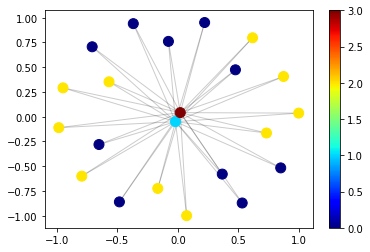

In [7]:
# get unique groups
groups = set(nx.get_node_attributes(G, 'label').values())
mapping = dict(zip(sorted(groups), count()))
nodes = G.nodes()
colors = [mapping[G.node[n]['label']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha = 0.2)
nc = nx.draw_networkx_nodes(G, pos, nodelist = nodes, node_color = colors, 
                            with_labels = False, node_size = 100, cmap = plt.cm.jet)
plt.colorbar(nc)
plt.show()